# TRAPPIST-1 b model with petitradTRANS

## Imports

In [1]:
from sys import path
path.append('/home/mathisb/Github/')

import os
os.environ['pRT_input_data_path'] = '/home/mathisb/projects/def-ncowan/input_data'

In [2]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 13})

In [3]:
%matplotlib  inline

In [4]:
from astropy import constants as const
from astropy import units as u

from starships.planet_obs import Planet

import starships.petitradtrans_utils as prt
from petitRADTRANS.physics import guillot_global
from petitRADTRANS import Radtrans
import petitRADTRANS.nat_cst as nc

import gc
from starships.spectrum import RotKerTransitCloudy

from astropy.modeling.physical_models import BlackBody as bb

## Planet info

In [5]:
# Specify planet name and parameters
# If not specified, the default parameters from exofile are taken.

pl_name = 'TRAPPIST-1 b'
planet_obj = Planet(pl_name)

# Most parameters are from trappist.one website
ap     = 0.01150*u.au       # semi-major axis of planet
R_star = 0.121*u.R_sun      # radius of star
R_pl   = 1.127*u.R_earth    # radius of planet
M_star = 0.089*const.M_sun  # mass of star
e      = 0                  # eccentricity
w      = 4.712389*u.rad     # argument of periapsis (equal to 270 degrees)
mid_tr = 2459514.805984833954*u.d  # mid-transit time (calculated from TTV BJD, Agol et al. 2021)

Getting TRAPPIST-1 b from ExoFile


/home/mathisb/HighRes/lib/python3.9/site-packages/exofile/archive.py:351: GetLocalFileWarning: DID NOT READ CUSTOM FILE. FileNotFoundError has occur when trying to query/read custom file.
  warn(GetLocalFileWarning(file="custom file", err=e))
/home/mathisb/HighRes/lib/python3.9/site-packages/astropy/units/quantity.py:486: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


-----------------------------------------------------
## H2O only

### Create model

In [6]:
# Molecules to include in the model (one at a time)
molecules = ['H2O']

# Name of the linelists in petitradTRANS (see petitradtrans_utils.py lines 115-150)
mols_linelists = {'H2O': 'H2O_main_iso'}

# Priors for abundances (comment out if don't know abundances a priori)
# mol_vmr_log_save = {'H2O': -10.460962699336015,
#                     'CO': -4.5809756604704672,
#                     'CO2': -9.32730066887895,
#                     'FeH': -9.924607502078075,
#                     'TiO': -7.2940528637809345,
#                     'VO': -7.878547571395368,
#                     'C2H2': -7.86252539345477,
#                     'HCN': -7.059113617089739,
#                     'OH': -4.42793780398837,
#                     'H-': -8.672778478857413}

In [7]:
# Pull parameters from petitradTRANS

limP = [-10, 0]  # log of TOA and surface pressure (unit: bar)
wl_range = [0.95, 2.35]  # wavelength range of instrument (unit: micrometers)

#-------------------------#

atmos_high, pressures = prt.gen_atm_all([mols_linelists[key] for key in molecules],
                                        continuum_opacities=['H-'],
                                        limP=limP,
                                        n_pts=50, 
                                        mode='lbl',  # set high resolution mode
                                        lbl_opacity_sampling=4,
                                        wl_range=wl_range)

/home/mathisb/HighRes/lib/python3.9/site-packages/petitRADTRANS/radtrans.py:100: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


['H2O_main_iso']
  Read line opacities of H2O_main_iso...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

Generating atmosphere with pressures from 1.0 to 1e-10
You are not getting the individual contributions of the species


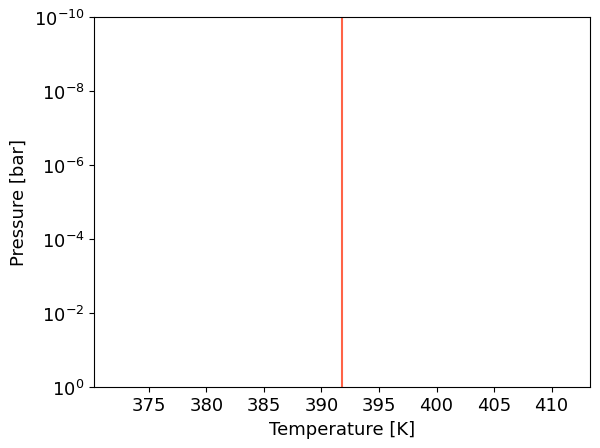

In [8]:
# Create T-P profile for small, rocky planets
# Assume an isotherm

T_eq = 391.8


############################################### WE WANT THE SKIN TEMPERATURE HERE, eq * (0.5)^1/4

#------------------#

# Temperature array
temperatures_day = np.full(len(pressures), T_eq)

# Plot T-P profile
plt.plot(temperatures_day, pressures, color="tomato")  # very important to keep this color

plt.xlabel("Temperature [K]")
plt.ylabel("Pressure [bar]")

plt.ylim(max(pressures), min(pressures))  # invert y axis
plt.yscale("log")

### Generating and plotting

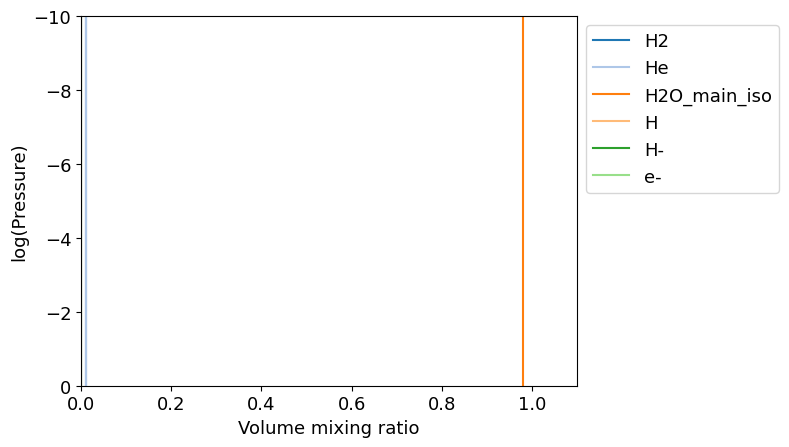

In [9]:
# Define volume mixing ratios of atmospheric molecules
VMRs = {"H2": 0.01,
        "He": 0.01,
        mols_linelists["H2O"]: 0.98,
        # do not touch the following
        "H": 1e-10,
        "H-": 1e-10,
        "e-": 1e-10
        }

#----------------------------------------------#

# Mean molecular weight of the atmosphere
MMW = prt.calc_MMW3(VMRs) * np.ones_like(pressures)

# Calculate mass fractions
mass_frac = dict()

for key in VMRs:
    mass_frac[key] = prt.mass_fraction(key, VMRs[key], MMW) * np.ones_like(pressures)

    
# Plot volume mixing ratios
cmap = plt.cm.get_cmap('tab20')  # colormap

for i, key in enumerate(VMRs.keys()):
    plt.plot(VMRs[key] * np.ones_like(pressures), np.log10(pressures), label=key, color=cmap.colors[i])

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlim(0, 1.1)
plt.ylim(0, -10)

plt.xlabel("Volume mixing ratio")
plt.ylabel("log(Pressure)")

plt.show()

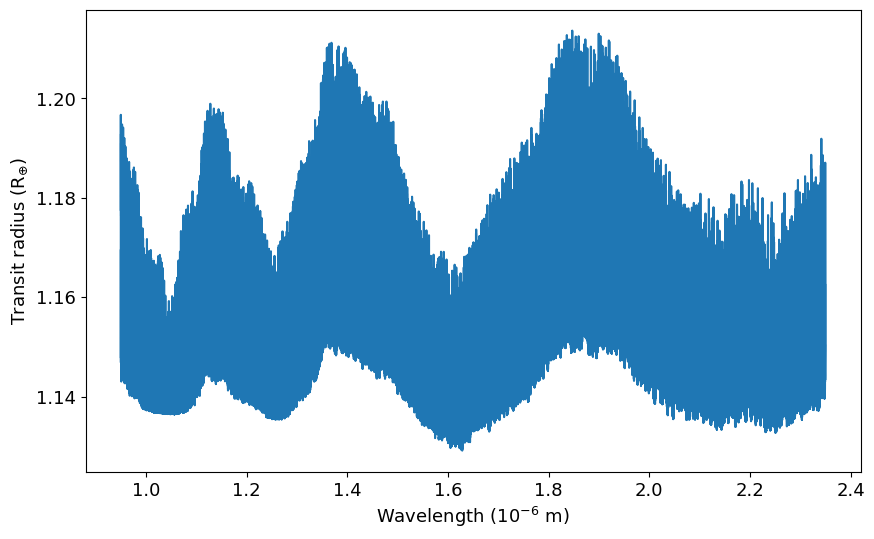

In [10]:
# Define the gravity and reference pressure P0 at the surface
P0 = 1  # units: bar
gravity = 0.81 * 980  # from trappist.one website, units: cm/s^2

#---------------------------------------------------------------#

# Calculate and plot the transmission spectrum
atmos_high.calc_transm(temperatures_day, mass_frac, gravity, MMW, R_pl=(R_pl.to(u.cm) / u.cm), P0_bar=P0)

# Plot transit radius
plt.rcParams['figure.figsize'] = (10, 6)

plt.plot(nc.c/atmos_high.freq/1e-4, atmos_high.transm_rad/nc.r_earth)

plt.xlabel('Wavelength ($10^{-6}$ m)')
plt.ylabel(r'Transit radius ($\rm R_{\oplus}$)')
plt.show()

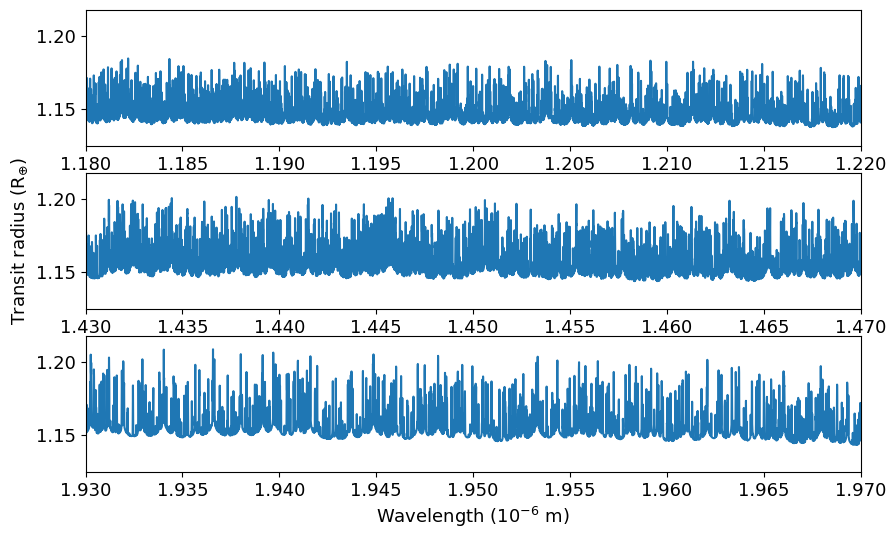

In [11]:
# Transit radius for different wavelength ranges (zoomed in)
list_wv_range = [(1.18, 1.22), (1.43, 1.47), (1.93, 1.97)]

#----------------------------------------------------------#

fig, ax = plt.subplots(len(list_wv_range), 1)

for ax_i, wv_rng in  zip(ax, list_wv_range):
    ax_i.plot(nc.c/atmos_high.freq/1e-4, atmos_high.transm_rad/nc.r_earth)
    ax_i.set_xlim(wv_rng)
    ax_i.set_xlabel('Wavelength ($10^{-6}$ m)')

ax[len(list_wv_range) // 2].set_ylabel(r'Transit radius ($\rm R_{\oplus}$)')
plt.show()

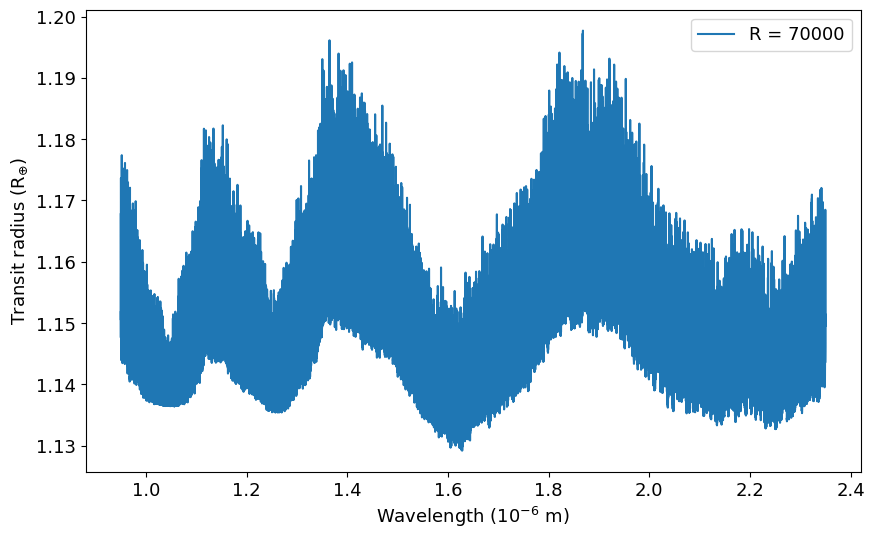

In [15]:
# Set resolution of the instrument
instr_res = 70000  # SPIRou

#----------------------------#

# Prepare model for cross-correlation (resample)
wave_mod, model_spec_co_day = prt.prepare_model(nc.c/atmos_high.freq/1e-4, atmos_high.transm_rad/nc.r_earth, 250000, Raf=instr_res, rot_params=None)

# Plot resampled model
plt.rcParams['figure.figsize'] = (10, 6)

plt.plot(wave_mod, model_spec_co_day, label="R = {}".format(instr_res))

plt.xlabel('Wavelength ($10^{-6}$ m)')
plt.ylabel(r'Transit radius ($\rm R_{\oplus}$)')
plt.legend()
plt.show()

In [16]:
# Save model to this directory
save_model_directory = "/home/mathisb/Github/HRS_models/"

#---------------------------------------------------------#

save_model_pl_name = pl_name.replace(" ", "")

np.savez(save_model_directory + "prt_model_{}_{}".format(save_model_pl_name, molecules[0]), wave_mod=wave_mod, model_spec=model_spec_co_day)

-----------------------------------------------------------
## CO2 only